##### Debug mode

In [1]:
%load_ext autoreload
%autoreload 2

##### For relative imports

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

##### Notebook

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
from interval import Interval
from observation import Observation
from constants import *
from datetime import timedelta
from tools import sequence_to_interval
plt.style.use('ggplot')
mpld3.enable_notebook()

reactor_site = "B1" #[site+tranche for site in ["A","B","C","D","E","F","G","H"] for tranche in ["1","2"]] + ["B3","B4","F3","F4"]

suffixes = [
"DEB1-1","DEB1-2","DEB1-3","DEB1-4", # Débit de fuite au joint 1 (Gamme Large)
# "DEB2-1","DEB2-2","DEB2-3","DEB2-4", # Débit de fuite au joint 1 (Gamme Étroite)
# "DEB3-1","DEB3-2","DEB3-3","DEB3-4","DEB3-5", # Débit d'injection au joint
"PUI-",  # Puissance thermique moyenne
"PRE-",  # Pression
# "TEM1-", # Température ligne d'injection aux joints (en * Celsius) ### A rapprocher de DEB3
# "TEM2-", # Température fuites joint 1
# "TEM3-1","TEM3-2","TEM3-3","TEM3-4",# Température eau joint 1 - 051PO ### A rapprocher de DEB1 DEB2
# "VIT-1","VIT-2","VIT-3","VIT-4"# Vitesse de rotation
] 

PATH = "../../Data/GMPP_IRSDI/"
obs = Observation(PATH,reactor_site,suffixes,verbose=1,ignore_keys=deb2)

print(str(len(obs.df))+" : Initial length of full df")
print(str(len(obs.full_concatenated_df))+" : New length of all selected intervals")

Loading in memory 6 observations...
Concatenation...
Changing isolated wrong values...
Forward Filling...
Backward Filling...
525887 : Initial length of full df
504474 : New length of all selected intervals


### Normal mode

In [4]:
# Re- exectute that everytime you have a 
# TypeError: super(type, obj): obj must be an instance or subtype of type
from scale import *
from rule import *
from tools import *
from score import *

### Defining Dataframe wrapper and highlight function

In [6]:
class MyDataFrame(object):
    def __init__(self, df):
        self.df = df
        self.list_df = [df]
        self.n_updates = 0
    def update(self,df):
        self.df = df
        self.list_df+=[df]
        self.n_updates += 1
    def last_indices_removed(self):
        return self.list_df[-2].index.difference(self.list_df[-1].index)
    def __str__(self):            
        return str(len(self.df))  if (len(self.df)<=999) else ">999"

# Style should be an attribute of the dataframe
    
def highlight_not_null(df_colors=['green'], null_color='red',unknown_color='white'):
    def style_function(s):
        colors = []
        for p in s: 
            if pd.isnull(p):
                colors+=[null_color]
            elif type(p) is MyDataFrame:
                colors+=[df_colors[p.n_updates]]
            else:
                colors+=[unknown_color]
        return ['background-color: '+color for color in colors]
    return style_function

### Initializing features_df

In [7]:
scales_tag = ["10m","3h","6h","1d","7d","30d","180d"]
features_tag = ["trend","step","spike","oscillation","correlation"]
features_df = pd.DataFrame(index=features_tag,columns=scales_tag,dtype=np.float64)
features_df.style.apply(highlight_not_null(['yellow']))

,10m,3h,6h,1d,7d,30d,180d
trend,nan,nan,nan,nan,nan,nan,nan
step,nan,nan,nan,nan,nan,nan,nan
spike,nan,nan,nan,nan,nan,nan,nan
oscillation,nan,nan,nan,nan,nan,nan,nan
correlation,nan,nan,nan,nan,nan,nan,nan


<hr style="height:3px">

### Define slice-resample functions

This is to handle the fact that we resample the dataframe, and then split it according to the periods of interest.

We remove the low regime, powering ups and powering downs of each cycle.

In [8]:
def score_list_df(list_df, feature):
    list_score_df = []
    for df in list_df:
        list_score_df += [feature.score(df,[deb1[0]])]
    return pd.concat(list_score_df, axis=0)
    
def list_subsampled(obs, scale):
    return obs.low_regime_intervals.split_between(scale.scale(obs.full_concatenated_df), time=timedelta(days=3))

def scale_feature(scale, feature):
    return score_list_df(list_subsampled(obs,scale),feature)

### Features description

In [9]:
features_list = [
    ("trend","1d",HourScale(1), Trend(24)),  # 1 days
    ("trend","7d",HourScale(6), Trend(28)),  # 7 days
    ("trend","30d",DayScale(1), Trend(30)),  # 30 days
    ("trend","180d",DayScale(6), Trend(30)),  # 180 days
    ("step","6h",MinutesScale(), Step(36)), # 6 hours
    ("step","1d",HourScale(1), Step(24)),   # 1 days
    ("step","7d",HourScale(6), Step(28)),   # 7 days
    ("correlation","6h",MinutesScale(), Correlation(36)), # 6 hours
    ("correlation","1d",HourScale(1), Correlation(24)),   # 1 days
    ("correlation","7d",HourScale(6), Correlation(28)),   # 7 days
    ("correlation","30d",DayScale(1), Correlation(30)),  # 30 days
    ("spike","10m",MinutesScale(), Spike()),
    ("oscillation","3h",MinutesScale(),Oscillation(3,18))
]

### Compute features

In [10]:
for rule_tag, scale_tag, scale, rule in features_list:
    features_df.loc[rule_tag,scale_tag] = MyDataFrame(scale_feature(scale,rule))

Visualization of the features dataframe

In [11]:
features_df.style.apply(highlight_not_null(['yellow']))

,10m,3h,6h,1d,7d,30d,180d
trend,nan,nan,nan,>999,>999,>999,484
step,nan,nan,>999,>999,>999,nan,nan
spike,>999,nan,nan,nan,nan,nan,nan
oscillation,nan,>999,nan,nan,nan,nan,nan
correlation,nan,nan,>999,>999,>999,>999,nan


In [44]:
with open('/home/mehlman/Data/features_df.pkl', 'wb') as output:
    pickle.dump(features_df, output, pickle.HIGHEST_PROTOCOL)

<hr style="height:3px">

### Describe scores

In [12]:
scales_tag = ["10m","3h","6h","1d","7d","30d","180d"]
scores_tag = ["trend_up","trend_down","step","spike","oscillation"]
scores_kept_df = pd.DataFrame(index=scores_tag,columns=scales_tag,dtype=np.float64)

### Compute scores

In [13]:
for scale_tag in scales_tag:
    trend_feature = features_df.loc["trend",scale_tag]
    scores_kept_df.loc["trend_up",scale_tag] = np.nan if pd.isnull(trend_feature) else MyDataFrame(trend_feature.df)
    scores_kept_df.loc["trend_down",scale_tag] = np.nan if pd.isnull(trend_feature) else MyDataFrame(-trend_feature.df)
    
    step_feature = features_df.loc["step",scale_tag]
    scores_kept_df.loc["step",scale_tag] = np.nan if pd.isnull(step_feature) else MyDataFrame(step_feature.df.abs())
    
    spike_feature = features_df.loc["spike",scale_tag]
    scores_kept_df.loc["spike",scale_tag] = np.nan if pd.isnull(spike_feature) else MyDataFrame(spike_feature.df)
    
    oscillation_feature = features_df.loc["oscillation",scale_tag]
    scores_kept_df.loc["oscillation",scale_tag] = np.nan if pd.isnull(oscillation_feature) else MyDataFrame(oscillation_feature.df)

Visualization of the scores dataframe

In [14]:
colors_scores_kept = ["#3afffb","#1ecebc","#25ed75","#26ad5c","#26ad5c","#26ad5c"]
scores_kept_df.style.apply(highlight_not_null(colors_scores_kept))

,10m,3h,6h,1d,7d,30d,180d
trend_up,nan,nan,nan,>999,>999,>999,484
trend_down,nan,nan,nan,>999,>999,>999,484
step,nan,nan,>999,>999,>999,nan,nan
spike,>999,nan,nan,nan,nan,nan,nan
oscillation,nan,>999,nan,nan,nan,nan,nan


### Schedule analysis

In [15]:
analysis_list = [
    ("trend_up","1d",ScoreAnalysis(2,timedelta(days=1))),  # 1 days
    ("trend_up","7d",ScoreAnalysis(2,timedelta(days=7))),  # 7 days
    ("trend_up","30d",ScoreAnalysis(2,timedelta(days=30))),  # 30 days
    ("trend_up","180d",ScoreAnalysis(2,timedelta(days=180))),  # 180 days
    ("trend_down","1d",ScoreAnalysis(2,timedelta(days=1))),  # 1 days
    ("trend_down","7d",ScoreAnalysis(2,timedelta(days=7))),  # 7 days
    ("trend_down","30d",ScoreAnalysis(2,timedelta(days=30))),  # 30 days
    ("trend_down","180d",ScoreAnalysis(2,timedelta(days=180))),  # 180 days
    ("step","6h",ScoreAnalysis(50,timedelta(hours=6))), # 6 hours
    ("step","1d",ScoreAnalysis(50,timedelta(days=1))),   # 1 days
    ("step","7d",ScoreAnalysis(50,timedelta(days=7))),   # 7 days
    ("spike","10m",ScoreAnalysis(100,timedelta(hours=3))),
    ("oscillation","3h",ScoreAnalysis(500,timedelta(hours=5)))
]

### Compute analysis

Here, we **update** the objects in `scores_kept_df` so that we keep track of the evolution of everything

In [16]:
for rule_tag, scale_tag, analysis in analysis_list:
    df_score = scores_kept_df.loc[rule_tag,scale_tag].df
    scores_kept_df.loc[rule_tag,scale_tag].update(analysis.analyse_and_sort(df_score))

Visualization of the modified scores dataframe

In [17]:
scores_kept_df.style.apply(highlight_not_null(colors_scores_kept))

,10m,3h,6h,1d,7d,30d,180d
trend_up,nan,nan,nan,154,22,6,1
trend_down,nan,nan,nan,156,30,7,4
step,nan,nan,158,36,10,nan,nan
spike,33,nan,nan,nan,nan,nan,nan
oscillation,nan,10,nan,nan,nan,nan,nan


###  Combine all results

#### Remove overlapping

In [18]:
def remove_overlapping(obj_list,widths):
    for obj, new_score in zip(obj_list, combine([obj.df for obj in obj_list],[],widths)):
        obj.update(new_score)

widths = [timedelta(days=1),timedelta(days=7),timedelta(days=30),timedelta(days=180)]
remove_overlapping(scores_kept_df.loc["trend_up"].dropna().values,widths)
remove_overlapping(scores_kept_df.loc["trend_down"].dropna().values,widths)

widths = [timedelta(hours=6),timedelta(days=1),timedelta(days=7),timedelta(days=30)]
remove_overlapping(scores_kept_df.loc["step"].dropna().values,widths)

In [19]:
scores_kept_df.style.apply(highlight_not_null(colors_scores_kept))

,10m,3h,6h,1d,7d,30d,180d
trend_up,nan,nan,nan,125,12,4,1
trend_down,nan,nan,nan,76,9,2,4
step,nan,nan,146,8,5,nan,nan
spike,33,nan,nan,nan,nan,nan,nan
oscillation,nan,10,nan,nan,nan,nan,nan


#### Remove inclusions

Step up $\subset $ Increasing Trend

Step down $\subset $ Decreasing Trend

Spike $\bigcap $ Oscillation $\neq \varnothing$

In [20]:
def update_df(scores_to_update,scores_exempt,widths,multiply = None):
    df_updates = combine([obj.df for obj in scores_to_update],[obj.df for obj in scores_exempt],widths,multiply)
    for s,df in zip(scores_to_update,df_updates):
        s.update(df)

#### Remove

In [21]:
scores_to_update = [scores_kept_df.loc["trend_up","1d"],scores_kept_df.loc["trend_down","1d"]] 
scores_exempt = [scores_kept_df.loc["step","6h"],scores_kept_df.loc["step","1d"]]
widths = [timedelta(days=0),timedelta(days=0),timedelta(hours=6),timedelta(days=1)]

update_df(scores_to_update,scores_exempt,widths)

scores_to_update = [scores_kept_df.loc["spike","10m"]]
scores_exempt = [scores_kept_df.loc["oscillation","3h"]]
widths = [timedelta(days=0),timedelta(hours=3)]

update_df(scores_to_update,scores_exempt,widths)

In [37]:
scores_kept_df.style.apply(highlight_not_null(colors_scores_kept))

,10m,3h,6h,1d,7d,30d,180d
trend_up,nan,nan,nan,91,12,4,1
trend_down,nan,nan,nan,44,9,2,4
step,nan,nan,146,8,5,nan,nan
spike,32,nan,nan,nan,nan,nan,nan
oscillation,nan,10,nan,nan,nan,nan,nan


In [43]:
import pickle

with open('/home/mehlman/Data/scores_kept_df.pkl', 'wb') as output:
    pickle.dump(scores_kept_df, output, pickle.HIGHEST_PROTOCOL)

with open('/home/mehlman/Data/scores_kept_df.pkl', 'rb') as input:
    scores_kept_df_2 = pickle.load(input)

In [38]:
features_df.loc["correlation","1d"].df.loc[scores_kept_df.loc["trend_up","1d"].df.index]

,score
2006-09-25 11:00:00,-0.690584
2006-09-30 18:00:00,-0.579398
2007-03-01 10:00:00,0.236234
2007-07-19 09:00:00,0.672403
2007-09-14 11:00:00,-0.431702
2007-11-12 07:00:00,0.120844
2008-04-09 11:00:00,0.550044
2008-04-14 20:00:00,-0.452041
2008-04-24 12:00:00,-0.082996
2008-05-12 21:00:00,-0.085220


In [24]:
#test.last_indices_removed()

In [27]:
# time_indices = scores_kept_df.loc["step","7d"].df.sort_values(by=["score"])[::-1].index
# features_df.loc["correlation","7d"].df.loc[time_indices]
#time_t = scores_kept_df.loc["step","6h"].df.sort_values(by=["score"])[::-1].index[6]
#time_indices = test.df.index#last_indices_removed()#scores_kept_df.loc["trend_down","1d"].df.sort_values(by=["score"])[::-1].index[:10]
#scores_kept_df.loc["step","6h"].df
#obj = scores_kept_df.loc["step","6h"]
#exploring = obj.list_df[-2].index.difference(obj.list_df[-1].index)

,score
2009-11-09 12:00:00,0.212687
2009-11-23 06:00:00,-0.014682
2009-10-27 12:00:00,0.183455
2015-08-15 06:00:00,0.098096
2006-06-16 06:00:00,-0.552052


In [ ]:
#time_t = exploring[0]
print(features_df.loc["step","6h"].df.loc[time_indices])
f, axes = plt.subplots(10,figsize=(5,20))
[obs.full_concatenated_df[time_t-timedelta(hours=12):time_t+timedelta(hours=12)][deb1[0]].plot(ax=axe) for time_t,axe in zip(time_indices,axes)]
plt.tight_layout()

In [ ]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression()
reg.fit(np.arange(100).reshape(-1,1),obs.full_concatenated_df.tail(100)[deb1[0]].values)

In [ ]:
for df in [obs.full_concatenated_df[time_t-timedelta(hours=12):time_t+timedelta(hours=12)][deb1[0]] for time_t in time_indices]:
    reg.fit(np.arange(len(df.values)).reshape(-1,1),df.values)
    print(reg.score(np.arange(len(df.values)).reshape(-1,1),df.values))

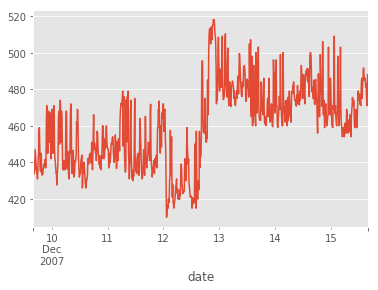

In [35]:
time_t = time_indices[1] 
delta = timedelta(days=3)
obs.full_concatenated_df[time_t-delta:time_t+delta][deb1[0]].plot()